In [1]:
import os
import pandas as pd
import numpy as np

Check 4 things:
<ol>
    <li> input type: returns / euclidean_distances
    <li> regularizer: kl or l1
    <li> regularizer hyperparameters: L1 
    <li> logs directory
</ol>

In [46]:
LOG_DIR = r'E:\phd\ae\data\spy\daily\results\returns\l1_regularizer\lambda-7e-7\logs'
# LOG_DIR = r'E:\phd\ae\data\spy\daily\results\returns\l1_regularizer\lambda-1e-6\logs'

In [47]:
# separate the log files into ones that need to rerun
# and files that ran but did or did not converge
def triage_files(log_dir):
    analyze = []
    rerun = []
    not_converged = []
    THR = 1.5e-06
    for file_name in os.listdir(log_dir):
        file_path = os.path.join(log_dir, file_name)
        lines = [line.rstrip('\n') for line in open(file_path)]
        if 'process completed' in lines[-1]:
            lines = use_last_run(lines)
            final_loss = get_final_loss(lines)
            tt = get_time_2_run(lines)
            epoch = get_epoch_2_converge(lines)
            gte_1pct_dim = get_dim(lines, "Dimension based on 1%:")
            upto_90pct_dim = get_dim(lines, "Dimension based upto 90%:")
            if final_loss > THR:
                not_converged.append((file_name[0:8], final_loss))
            else:
                analyze.append((file_name[0:8], tt, epoch, gte_1pct_dim, upto_90pct_dim))
        else:
            rerun.append(file_name[0:8])
    return analyze, rerun, not_converged

# given the files that completed we need to check if the 
# final loss converged        
def get_final_loss(lines):
    for line in lines:
        if "final loss:" in line:
            return float(line.split(" ")[-1])        

def get_time_2_run(lines):
    return int(lines[-1].split(" ")[-2])

def get_epoch_2_converge(lines):
    for line in lines:
        if "THR" in line:
            epoch = line.split(" ")[1]
            return epoch.rstrip(":")

#"Dimension based on 1%:"
#"Dimension based upto 90%:"" 

def get_dim(lines, contains_str):
    for line in lines:
        if contains_str in line:
            return int(line.strip().split(" ")[-1])        

            
def use_last_run(lines):
    line_no = []
    i = 0
    for line in lines:
        if "Date to process:" in line:
            line_no.append(i)
        i = i+1    
    if len(line_no) > 1:
        line_no = sorted(line_no)
        lines = lines[line_no[-1]:]
    return lines

In [48]:
# file_path = os.path.join(LOG_DIR, "20080102.log")
# lines = [line.rstrip('\n') for line in open(file_path)]

Triage all the log files into 3 buckets: the ones we want to analyze, rerun or did not converge even after 30K epochs.

In [49]:
analyze, rerun, not_converged = triage_files(LOG_DIR)

In [50]:
print('Total # of files: {}'.format(len(analyze) + len(rerun) + len(not_converged)))
print('Successully completed and converged: {}'.format(len(analyze)))
print('Need to rerun: {}'.format(len(rerun)))
print('Completed by did not converge: {}'.format(len(not_converged)))

Total # of files: 567
Successully completed and converged: 567
Need to rerun: 0
Completed by did not converge: 0


Check the dates that completed the process but training loss did not converge below 1.5e-06

In [51]:
not_converged

[]

##### List of dates we need to rerun 

In [52]:
for date in rerun:
    s = 'sbatch -o ../out/{}.log russell3k-ae-l1.py {}'.format(date, date)
    print(s)

##### List of dates did not converge ( EPOCH = 30K )

In [53]:
for date in not_converged:
    s = 'sbatch -o ../out/{}.log russell3k-ae-l1.py {}'.format(date[0], date[0])
    print(s)

##### Check time to run and epochs taken for Early Stopping

In [76]:
df = pd.DataFrame(analyze)
df.columns = ['Date', 'Time Taken', 'Epoch', 'GTE 1%', 'UPTO 90%']
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df.set_index(df['Date'], inplace=True)
df.drop(columns=['Date'], inplace=True)  
df['5D GTE 1% MA'] = df['GTE 1%'].rolling(window=5).mean()
df['5D UPTO 90% MA'] = df['UPTO 90%'].rolling(window=5).mean()

##### Load S&P data and analyze

In [77]:
# --------------------------------------------------------------------------------------
# load spy index level for last 20 years
# this is required for plotting dimensionality
# time series
# --------------------------------------------------------------------------------------
def load_spy_data(spy_data_file):
    spy_df = pd.read_csv(spy_data_file)
    spy_df['Date'] = pd.to_datetime(spy_df['Date'], format='%m/%d/%Y')
    spy_df.set_index(spy_df['Date'], inplace=True)
    spy_df.drop(columns=['Date'], inplace=True)
    return spy_df

In [78]:
spy_data_file = r'E:\phd\ae\data\spy_500_data.csv'

In [79]:
# merge S&P data with metrics based on date
# lookup S&P index level
spy_df = load_spy_data(spy_data_file)
df = df.join(spy_df[['Adj Close']], how='left')

In [80]:
df.dropna(inplace=True)

In [81]:
# df.to_csv(r'E:\phd\ae\data\spy\daily\summary\returns\l1_regularizer\lambda-1e-8\2008-September.csv')

In [82]:
import bokeh.plotting as bp
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models import LinearAxis, Range1d

import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
output_notebook()

Loading BokehJS ...

In [84]:
ts = df.index
df_ = df[(ts >= pd.Timestamp(2008,1,1)) & (ts <= pd.Timestamp(2009,12,31))]
ts_ = df_.index

snp_min = 600
snp_max = 1500

# -----------------------------
# Figure 1
# ------------------------------
p1 = bp.figure(width=300, height=300, x_axis_type="datetime", y_range=(0, 64), title='7e-7 2008-2009 GTE 1%')
p1.line(x=ts_, y=df_['5D GTE 1% MA'], color='green', legend='5D GTE 1% MA', line_width=1.0)
p1.line(x=ts_, y=df_['GTE 1%'], color='lightgray', legend='GTE 1%', line_width=1.0)

p1.xaxis.axis_label = "Date"
p1.yaxis.axis_label = "Dimension"
p1.legend.location = "top_right"
p1.legend.orientation = "horizontal"
p1.legend.label_text_font_size = '7pt'

p1.extra_y_ranges = {"spy": Range1d(start=snp_min, end=snp_max)}
p1.line(ts_, df_['Adj Close'], color="red", y_range_name="spy", line_width=1)
p1.add_layout(LinearAxis(y_range_name="spy", axis_label="S&P 500 Index"), 'right')

# -----------------------------
# Figure 2
# ------------------------------
p2 = bp.figure(width=300, height=300, x_axis_type="datetime", y_range=(0, 64), title='7e-7 2008-2009 UPTO 90%')
p2.line(x=ts_, y=df_['5D UPTO 90% MA'], color='blue', legend='5D UPTO 90% MA', line_width=1.0)
p2.line(x=ts_, y=df_['UPTO 90%'], color='lightgray', legend='UPTO 90%', line_width=1.0)

p2.xaxis.axis_label = "Date"
p2.yaxis.axis_label = "Dimension"
p2.legend.location = "bottom_left"
p2.legend.orientation = "horizontal"
p2.legend.label_text_font_size = '7pt'

p2.extra_y_ranges = {"spy": Range1d(start=snp_min, end=snp_max)}
p2.line(ts_, df_['Adj Close'], color="red", y_range_name="spy", line_width=1)
p2.add_layout(LinearAxis(y_range_name="spy", axis_label="S&P 500 Index"), 'right')


grid = gridplot([[p1], [p2]], plot_width=900, plot_height=400) # 

bp.show(grid)

In [89]:
ts = df.index
df_ = df[(ts >= pd.Timestamp(2009,3,1)) & (ts <= pd.Timestamp(2009,3,31))]
ts_ = df_.index

snp_min = 650
snp_max = 850

# -----------------------------
# Figure 1
# ------------------------------
p1 = bp.figure(width=300, height=300, x_axis_type="datetime", y_range=(30, 50), title='7e-7 March 2009 GTE 1%')
# p1.line(x=ts_, y=df_['10D GTE 1% MA'], color='green', legend='10D GTE 1% MA', line_width=1.0)
p1.line(x=ts_, y=df_['GTE 1%'], color='lightgray', legend='GTE 1%', line_width=1.0)

p1.xaxis.axis_label = "Date"
p1.yaxis.axis_label = "Dimension"
p1.legend.location = "top_right"
p1.legend.orientation = "horizontal"
p1.legend.label_text_font_size = '7pt'

p1.extra_y_ranges = {"spy": Range1d(start=snp_min, end=snp_max)}
p1.line(ts_, df_['Adj Close'], color="red", y_range_name="spy", line_width=1)
p1.add_layout(LinearAxis(y_range_name="spy", axis_label="S&P 500 Index"), 'right')

# -----------------------------
# Figure 2
# ------------------------------
p2 = bp.figure(width=300, height=300, x_axis_type="datetime", y_range=(30, 50), title='7e-7 March 2009 UPTO 90%')
# p2.line(x=ts_, y=df_['10D UPTO 90% MA'], color='blue', legend='10D UPTO 90% MA', line_width=1.0)
p2.line(x=ts_, y=df_['UPTO 90%'], color='lightgray', legend='UPTO 90%', line_width=1.0)

p2.xaxis.axis_label = "Date"
p2.yaxis.axis_label = "Dimension"
p2.legend.location = "bottom_left"
p2.legend.orientation = "horizontal"
p2.legend.label_text_font_size = '7pt'

p2.extra_y_ranges = {"spy": Range1d(start=snp_min, end=snp_max)}
p2.line(ts_, df_['Adj Close'], color="red", y_range_name="spy", line_width=1)
p2.add_layout(LinearAxis(y_range_name="spy", axis_label="S&P 500 Index"), 'right')


grid = gridplot([[p1], [p2]], plot_width=900, plot_height=400) # 

bp.show(grid)

##### Use neighboring z_i's to determine the dimensionality

In [90]:
# --------------------------------------------------------------------------------------
# for every day we have the z_i values
# we will be using this for creating the analytics/metrics
# --------------------------------------------------------------------------------------
def create_z_matrix(input_dir, summary_dir, out_file_name):
    dates = []
    for file_name in os.listdir(input_dir):
        if '_encoded' in file_name:
            file_path = os.path.join(input_dir, file_name)
            dates.append(file_name[0:8])

    df_z = pd.DataFrame(columns=dates)
    for i in np.arange(len(dates)):
        file_name = '{}_encoded.dat'.format(dates[i])
        file_path = os.path.join(input_dir, file_name)
        m = np.load(file_path) 
        z = np.mean(m, axis=0)
        df_z[dates[i]] = z

    df_z_T = df_z.transpose()
    df_z_T['Date'] = pd.to_datetime(df_z_T.index, format='%Y%m%d')
    df_z_T.set_index(df_z_T['Date'], inplace=True)
    df_z_T.drop(columns=['Date'], inplace=True)    
    
    save_df(df_z_T, summary_dir, out_file_name)
    
    return df_z_T

# ----------------------------------------------------------------------------------
# Calculate mean and standard deviation based on number of days
# we will use 5, 10, 15, 20, 25, and 30 days.
# ----------------------------------------------------------------------------------
def calculate_moving_avg(df_, ndays, scale):
    dates = []
    mu = []
    rho = []
    for i in np.arange(0, len(df_)-ndays+1):
        m = df_.iloc[i:i+ndays,:].copy()
        mu.append(np.mean(m.values))
        rho.append(np.std(m.values))
        dates.append(m.index[-1])
        
    df = pd.DataFrame()
    df['Date'] = dates
    df['{}D MA'.format(ndays)] = mu
    df['{}D STDEV'.format(ndays)] = rho
    df['{}D LB'.format(ndays)] = df['{}D MA'.format(ndays)]  - scale*df['{}D STDEV'.format(ndays)]
    df['{}D UB'.format(ndays)] = df['{}D MA'.format(ndays)]  + scale*df['{}D STDEV'.format(ndays)]
    
    # set the index for metrics dataframe
    df.set_index(df['Date'], inplace=True)
    df.drop(columns=['Date'], inplace=True)          
    
    return df

def calculate_dimension(df_, df_mean, ndays, spy_data_file):
    dates = []
    dims = []
    lb_col_hdr = '{}D LB'.format(ndays)
    ub_col_hdr = '{}D UB'.format(ndays)
    for i in np.arange(0, len(df_mean)):
        date = df_mean.index[i]
        data = df_.loc[date].copy() 
        lb = df_mean.loc[date][lb_col_hdr]
        ub = df_mean.loc[date][ub_col_hdr]
        ndim = 64 - data[(data >= lb) & (data <= ub)].count()
        dates.append(date)
        dims.append(ndim)        
        
    df = pd.DataFrame()
    df['Date'] = dates
    df['Dimension'] = dims
    
    # set the index for metrics dataframe
    df.set_index(df['Date'], inplace=True)
    df.drop(columns=['Date'], inplace=True)          
    
    spy_df = load_spy_data(spy_data_file)
    df = df.join(spy_df[['Adj Close']], how='left')
    return df

# --------------------------------------------------------------------------------------
# save analytics file
# --------------------------------------------------------------------------------------
def save_df(df, file_path, file_name):
    out_file_path = os.path.join(file_path, file_name)
    df.to_csv(out_file_path) 

In [91]:
results_dir = r'E:\phd\ae\data\spy\daily\results\returns\l1_regularizer\lambda-7e-7\output'
summary_dir = r'E:\phd\ae\data\spy\daily\summary\returns\l1_regularizer\lambda-7e-7'

# results_dir = r'E:\phd\ae\data\spy\daily\results\returns\l1_regularizer\lambda-1e-8\output'
# summary_dir = r'E:\phd\ae\data\spy\daily\summary\returns\l1_regularizer\lambda-1e-8'

In [92]:
df_z = create_z_matrix(results_dir, summary_dir, 'z-lambda-1e-8.csv')
df_z_mean = calculate_moving_avg(df_z, 30, 1)
df_result = calculate_dimension(df_z, df_z_mean, 30, spy_data_file)

In [100]:
df_result.head()

Dimension  Adj Close  MA Dimension
Date                                          
2008-03-27          4    1325.76           7.0
2008-03-28          7    1315.22           6.0
2008-03-31          5    1322.70           5.0
2008-04-01          2    1370.18           4.0
2008-04-02          5    1367.53           5.0

In [94]:
df_result['MA Dimension'] = df_result['Dimension'].rolling(window=5).mean()
df_result = df_result[29:]
df_result = df_result.round({'MA Dimension': 0})
# df_result.head()

##### Plot using z_i moving average

In [95]:
ts = df_result.index
df_ = df_result[(ts >= pd.Timestamp(2008,1,1)) & (ts <= pd.Timestamp(2009,12,31))]
ts_ = df_.index

In [102]:
snp_min = 650
snp_max = 1500

# -----------------------------
# Figure 1
# ------------------------------
p1 = bp.figure(width=300, height=300, x_axis_type="datetime", y_range=(0, 50), title='64 - [30DMA mean+/- stddev]')
p1.line(x=ts_, y=df_['MA Dimension'], color='green', legend='MA Dimension', line_width=1.0)
p1.line(x=ts_, y=df_['Dimension'], color='lightgray', legend='Dimension', line_width=1.0)

p1.xaxis.axis_label = "Date"
p1.yaxis.axis_label = "Dimension"
p1.legend.location = "top_right"
p1.legend.orientation = "horizontal"
p1.legend.label_text_font_size = '7pt'

p1.extra_y_ranges = {"spy": Range1d(start=snp_min, end=snp_max)}
p1.line(ts_, df_['Adj Close'], color="red", y_range_name="spy", line_width=1)
p1.add_layout(LinearAxis(y_range_name="spy", axis_label="S&P 500 Index"), 'right')

# -----------------------------
# Figure 2
# ------------------------------
# p2 = bp.figure(width=300, height=300, x_axis_type="datetime", y_range=(0, 60), title='UPTO 90%')
# p2.line(x=ts_, y=df_['10D UPTO 90% MA'], color='blue', legend='10D UPTO 90% MA', line_width=1.0)

# p2.xaxis.axis_label = "Date"
# p2.yaxis.axis_label = "Dimension"
# p2.legend.location = "top_right"
# p2.legend.orientation = "horizontal"
# p2.legend.label_text_font_size = '7pt'

# p2.extra_y_ranges = {"spy": Range1d(start=snp_min, end=snp_max)}
# p2.line(ts_, df_['Adj Close'], color="red", y_range_name="spy", line_width=1)
# p2.add_layout(LinearAxis(y_range_name="spy", axis_label="S&P 500 Index"), 'right')


grid = gridplot([[p1]], plot_width=900, plot_height=400) # 

bp.show(grid)

In [364]:
df_z.head()

0             1             2         3             4   \
Date                                                                           
2008-01-02  5.370788e-04  3.277079e-03  1.186822e-07  0.000002  1.953777e-07   
2008-01-03  6.058219e-03  1.520076e-06  1.816714e-07  0.002193  6.646234e-08   
2008-01-04  1.759251e-06  1.204075e-07  1.300877e-03  0.001362  8.078516e-07   
2008-01-07  2.051206e-06  8.000529e-07  1.750120e-07  0.009657  1.332614e-07   
2008-01-08  4.261749e-07  7.097174e-03  1.396879e-03  0.005129  1.251695e-02   

                      5             6             7             8   \
Date                                                                 
2008-01-02  1.262456e-06  2.260085e-02  1.437794e-07  1.491834e-07   
2008-01-03  2.585653e-06  1.758595e-02  1.816690e-07  2.917575e-03   
2008-01-04  3.370159e-03  1.715904e-07  4.453095e-08  9.924081e-06   
2008-01-07  1.736361e-05  7.247912e-03  2.640739e-07  1.247223e-02   
2008-01-08  3.937858e-07  2.811005e-03  7.826025e-04  1.679381e-02   

                      9       ...                 54        55            56  \
Date                          ...                                              
2008-01-02  1.639053e-03      ...       1.199970e-02  0.000003  4.318103e-07   
2008-01-03  6.974008e-05      ...       3.588395e-07  0.018858  9.251880e-08   
2008-01-04  2.435407e-06      ...       2.358173e-07  0.006277  9.823284e-07   
2008-01-07  6.811580e-08      ...       3.090216e-07  0.001885  1.318432e-03   
2008-01-08  1.307630e-03      ...       5.181234e-07  0.001156  1.131461e-06   

                      57        58        59            60            61  \
Date                                                                       
2008-01-02  3.503531e-04  0.000005  0.000003  1.662428e-06  2.780423e-07   
2008-01-03  3.691516e-07  0.002254  0.009124  1.132286e-06  3.364055e-07   
2008-01-04  1.446038e-02  0.000002  0.005597  9.162315e-08  2.569896e-03   
2008-01-07  2.502522e-03  0.000001  0.000005  1.162735e-02  1.628654e-07   
2008-01-08  1.887958e-06  0.001182  0.015056  7.227704e-03  1.075278e-02   

                      62            63  
Date                                    
2008-01-02  1.177339e-06  2.004661e-07  
2008-01-03  2.180312e-07  5.184357e-07  
2008-01-04  2.152549e-07  1.005987e-02  
2008-01-07  2.092709e-04  1.119053e-02  
2008-01-08  1.033851e-07  2.446596e-07  

[5 rows x 64 columns]

In [365]:
len(df_z.loc['2008-01-02'])

64

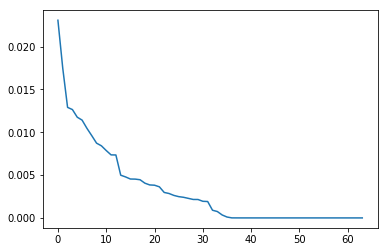

In [366]:
x = np.arange(len(df_z.loc['2008-09-15']))
y = sorted(df_z.loc['2008-09-15'].values, reverse=True)
plt.plot(x, y)

In [367]:
x = np.arange(len(df_z.loc['2008-01-09']))
y = sorted(df_z.loc['2008-01-02'].values, reverse=True)
plt.plot(x, y)

In [368]:
input_dir = r'E:\phd\ae\data\spy\daily\results\returns\l1_regularizer\lambda-7e-7\output'
# dates_2_compare = ['20080910', '20080911', '20080912', '20080915', '20080916', '20080919']
# dates_2_compare = ['20080102', '20080103', '20080107', '20080109', '20080110', '20080111']
dates_2_compare = ['20080915', '20080916', '20080917', '20090320', '20090323', '20090324']
df_cmp = pd.DataFrame(columns=dates_2_compare)
for i in np.arange(len(dates_2_compare)):
    file_name = '{}_encoded.dat'.format(dates_2_compare[i])
    file_path = os.path.join(input_dir, file_name)
    m = np.load(file_path) 
    z = np.mean(m, axis=0)
    z_sort = sorted(z)
    df_cmp[dates_2_compare[i]] = z_sort

output_notebook()

x = np.arange(len(df_cmp))
y1 = df_cmp[dates_2_compare[0]]
y2 = df_cmp[dates_2_compare[1]]
y3 = df_cmp[dates_2_compare[2]]
y4 = df_cmp[dates_2_compare[3]]
y5 = df_cmp[dates_2_compare[4]]
y6 = df_cmp[dates_2_compare[5]]

y_min = np.min(df_cmp.min())
y_max = np.max(df_cmp.max())

p1 = bp.figure(x_range=(0, len(df_cmp)), y_range=(y_min, y_max), plot_width=250, plot_height=250, title=dates_2_compare[0])
p1.circle(x, y1, fill_alpha=0.6, line_color=None)

p2 = bp.figure(x_range=(0, len(df_cmp)), y_range=(y_min, y_max), plot_width=250, plot_height=250,  title=dates_2_compare[1])
p2.circle(x, y2, fill_alpha=0.6, line_color=None)

p3 = bp.figure(x_range=(0, len(df_cmp)), y_range=(y_min, y_max), plot_width=250, plot_height=250,  title=dates_2_compare[2])
p3.circle(x, y3, fill_alpha=0.6, line_color=None)

p4 = bp.figure(x_range=(0, len(df_cmp)), y_range=(y_min, y_max), plot_width=250, plot_height=250,  title=dates_2_compare[3])
p4.circle(x, y4, fill_alpha=0.6, line_color=None)

p5 = bp.figure(x_range=(0, len(df_cmp)), y_range=(y_min, y_max), plot_width=250, plot_height=250,  title=dates_2_compare[4])
p5.circle(x, y5, fill_alpha=0.6, line_color=None)

p6 = bp.figure(x_range=(0, len(df_cmp)), y_range=(y_min, y_max), plot_width=250, plot_height=250,  title=dates_2_compare[5])
p6.circle(x, y6, fill_alpha=0.6, line_color=None)

grid = gridplot([[p1, p2, p3], [p4, p5, p6]], plot_width=300, plot_height=300)

bp.show(grid)

Loading BokehJS ...

##### Plot only $z_i >= 0.005$ 

In [142]:
def count_gt_thrreshold_dimension(df_, threshold, spy_data_file):
    dates = []
    dims = []
    for i in np.arange(0, len(df_)):
        date = df_.index[i]
        data = df_.loc[date].copy() 
        ndim = data[(data > threshold)].count()
        dates.append(date)
        dims.append(ndim)        
        
    df = pd.DataFrame()
    df['Date'] = dates
    df['COUNT > {}'.format(str(threshold))] = dims
    
    # set the index for metrics dataframe
    df.set_index(df['Date'], inplace=True)
    df.drop(columns=['Date'], inplace=True)          
    
    spy_df = load_spy_data(spy_data_file)
    df = df.join(spy_df[['Adj Close']], how='left')
    return df

In [151]:
threshold = 0.008
df_z = create_z_matrix(results_dir, summary_dir, 'z-lambda-7e-7.csv')
df_result = count_gt_thrreshold_dimension(df_z, threshold, spy_data_file)
df_result['5D MA COUNT > {}'.format(threshold)] = df_result['COUNT > {}'.format(threshold)].rolling(window=5).mean()

In [152]:
df_result.head()

COUNT > 0.008  Adj Close  5D MA COUNT > 0.008
Date                                                     
2008-01-02             13    1447.16                  NaN
2008-01-03             11    1447.16                  NaN
2008-01-04              9    1411.63                  NaN
2008-01-07             12    1416.18                  NaN
2008-01-08             10    1390.19                 11.0

In [153]:
output_notebook()

Loading BokehJS ...

In [154]:

ts = df_result.index
df_ = df_result[(ts >= pd.Timestamp(2008,1,1)) & (ts <= pd.Timestamp(2009,12,31))]
ts_ = df_.index

snp_min = 650
snp_max = 1600

# -----------------------------
# Figure 1
# ------------------------------
col_hdr = 'COUNT > {}'.format(threshold)
col_hdr_ma = '5D MA COUNT > {}'.format(threshold)
p1 = bp.figure(width=300, height=300, x_axis_type="datetime", y_range=(0, 25), title=col_hdr)
p1.line(x=ts_, y=df_[col_hdr], color='lightgray', legend=col_hdr, line_width=1.0)
p1.line(x=ts_, y=df_[col_hdr_ma], color='green', legend=col_hdr_ma, line_width=1.0)

p1.xaxis.axis_label = "Date"
p1.yaxis.axis_label = "Dimension"
p1.legend.location = "top_left"
p1.legend.orientation = "horizontal"
p1.legend.label_text_font_size = '7pt'

p1.extra_y_ranges = {"spy": Range1d(start=snp_min, end=snp_max)}
p1.line(ts_, df_['Adj Close'], color="red", y_range_name="spy", line_width=1)
p1.add_layout(LinearAxis(y_range_name="spy", axis_label="S&P 500 Index"), 'right')

grid = gridplot([[p1]], plot_width=900, plot_height=400) # 

bp.show(grid)

In [108]:
df_result.to_csv(r'E:\phd\ae\data\spy\daily\summary\returns\l1_regularizer\lambda-7e-7\df_result.csv')